In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Add CS7643 shortcut to drive
%cd "drive/MyDrive/CS7643"

/content/drive/.shortcut-targets-by-id/1fpFY6WY_b8xNO6G978MNvFi4JMMUobLq/CS7643


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import ast
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pip install scikit-learn --upgrade
!pip install seaborn

# Helper Functions

In [ ]:
def clean_embedding_string(s):
  s = s[1:-1].strip()
  return [float(i) for i in s.split()]

In [ ]:
def preprocessing(data):
  data = data.drop(data.columns[0], axis=1)

  data['title_embeddings'] = data['title_embeddings'].apply(clean_embedding_string)

  data['one_hot_artist'] = data['one_hot_artist'].apply(ast.literal_eval)
  data['one_hot_artist'] = data['one_hot_artist'].apply(lambda x: [float(i) for i in x])

  data['one_hot_genre'] = data['one_hot_genre'].apply(ast.literal_eval)
  data['one_hot_genre'] = data['one_hot_genre'].apply(lambda x: [float(i) for i in x])

  title_embeddings = pd.DataFrame(data['title_embeddings'].tolist(),
                                columns=[f'title_embedding_{i}'
                                         for i in range(len(data['title_embeddings'][0]))])
  artist_one_hot = pd.DataFrame(data['one_hot_artist'].tolist(),
                                columns=[f'artist_{i}'
                                         for i in range(len(data['one_hot_artist'][0]))])
  genre_one_hot = pd.DataFrame(data['one_hot_genre'].tolist(),
                                columns=[f'genre_{i}'
                                         for i in range(len(data['one_hot_genre'][0]))])
  regular_features = [
    'duration', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_mins',
    'release_year', 'release_month', 'release_day', 'popularity'
  ]

  data = pd.concat([data[regular_features],
                    title_embeddings, artist_one_hot, genre_one_hot], axis=1)

  cols_to_check = ['release_year', 'release_month', 'release_day']
  data = data.dropna(subset=cols_to_check)


  X = data.drop('popularity', axis=1)
  y = data['popularity']

  return X, y

In [ ]:
def preprocessing_no_encodings(original_data, preprocessed_data):
  original_data = original_data.drop(original_data.columns[0], axis=1)

  preprocessed_data['title_embeddings'] = preprocessed_data['title_embeddings'].apply(clean_embedding_string)

  title_embeddings = pd.DataFrame(preprocessed_data['title_embeddings'].tolist(),
                                columns=[f'title_embedding_{i}'
                                         for i in range(len(preprocessed_data['title_embeddings'][0]))])

  regular_features = [
    'duration', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_mins',
    'popularity', 'artist_name', 'genre'
  ]

  new_data = pd.concat([original_data[regular_features],
                        preprocessed_data[['release_year', 'release_month', 'release_day']],
                        title_embeddings],
                       axis=1)

  cols_to_check = ['release_year', 'release_month', 'release_day']
  new_data = new_data.dropna(subset=cols_to_check)


  numerical_columns = ['duration', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_mins', 'release_year', 'release_month', 'release_day']
  categorical_columns = ['artist_name', 'genre']


  X = new_data.drop('popularity', axis=1)
  y = new_data['popularity']

  return X[numerical_columns], X[categorical_columns], y

In [ ]:
def train_linear_regression(X_train, X_test, y_train, y_test):
  lr_regressor = LinearRegression()
  lr_regressor.fit(X_train, y_train)

  y_pred = lr_regressor.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  metrics = [f"Mean Squared Error: {mse:.4f}", f"R² Score: {r2:.4f}"]
  print(metrics)
  return lr_regressor, y_pred

In [ ]:
def train_random_forest(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42, n_jobs=-1):
  model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  metrics = [f"Mean Squared Error: {mse:.4f}", f"R² Score: {r2:.4f}"]
  print(metrics)
  return model, y_pred

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

def train_mlp(X_train, X_test, y_train, y_test, epochs=50, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_t = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    model = MLP(input_dim=X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_t)
        mse = criterion(preds, y_test_t).item()
        r2 = r2_score(y_test_t.cpu().numpy(), preds.cpu().numpy())

    print(f"[MLP] MSE: {mse:.4f} | R²: {r2:.4f}")
    return model

def train_mlp_standard_scale(X_train, X_test, y_train, y_test, epochs=50, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).squeeze().to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).squeeze().to(device)

    model = MLP(input_dim=X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        train_loss = criterion(output, y_train_t)
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            preds = model(X_test_t)
            val_loss = criterion(preds, y_test_t).item()
            val_losses.append(val_loss)

        r2 = r2_score(y_test_t.cpu().numpy(), preds.cpu().numpy())
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss.item():.4f} | Validation Loss: {val_loss:.4f} | R²: {r2:.4f}")

    print(f"Final [MLP] MSE: {val_loss:.4f} | R²: {r2:.4f}")

    return model, train_losses, val_losses

In [ ]:
class MLPWithEmbeddings(nn.Module):
    def __init__(self, num_features, cat_dims, embed_dim=16):
        super().__init__()
        # Create embedding layers for each categorical feature
        self.embeddings = nn.ModuleList(
            [nn.Embedding(dim, embed_dim) for dim in cat_dims]
        )
        total_embed = embed_dim * len(cat_dims)
        self.fc = nn.Sequential(
            nn.Linear(num_features + total_embed, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x_num, x_cat):
        # Process each categorical feature through its embedding layer
        embedded = []
        for i, emb in enumerate(self.embeddings):
            # Ensure indices are within bounds
            x_cat_i = x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)
            embedded.append(emb(x_cat_i))

        # Concatenate embedded categorical features with numerical features
        x = torch.cat(embedded + [x_num], dim=1)
        return self.fc(x).squeeze()


def train_mlp_with_embeddings(
    X_train_num,
    X_test_num,
    X_train_cat,
    X_test_cat,
    y_train,
    y_test,
    cat_dims,
    epochs=50,
    lr=1e-3,
):
    device = torch.device("cpu")
    torch.cuda.is_available = (lambda: False)

    print(
        f"X_train_num shape: {X_train_num.shape if hasattr(X_train_num, 'shape') else 'unknown'}"
    )
    print(
        f"X_train_cat shape: {X_train_cat.shape if hasattr(X_train_cat, 'shape') else 'unknown'}"
    )
    print(f"cat_dims: {cat_dims}")


    if isinstance(X_train_num, torch.Tensor):
        X_train_num = X_train_num.cpu().numpy()
    if isinstance(X_test_num, torch.Tensor):
        X_test_num = X_test_num.cpu().numpy()
    if isinstance(X_train_cat, torch.Tensor):
        X_train_cat = X_train_cat.cpu().numpy()
    if isinstance(X_test_cat, torch.Tensor):
        X_test_cat = X_test_cat.cpu().numpy()
    if isinstance(y_train, torch.Tensor):
        y_train = y_train.cpu().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()

    X_train_num = torch.tensor(X_train_num, dtype=torch.float32)
    X_test_num = torch.tensor(X_test_num, dtype=torch.float32)


    for i, dim in enumerate(cat_dims):
        if np.max(X_train_cat[:, i]) >= dim:
            print(f"Warning: Category {i} out of bounds, clipping.")
            X_train_cat[:, i] = np.clip(X_train_cat[:, i], 0, dim - 1)
        if np.max(X_test_cat[:, i]) >= dim:
            print(f"Warning: Category {i} out of bounds, clipping.")
            X_test_cat[:, i] = np.clip(X_test_cat[:, i], 0, dim - 1)

    X_train_cat = torch.tensor(X_train_cat, dtype=torch.long)
    X_test_cat = torch.tensor(X_test_cat, dtype=torch.long)

    if hasattr(y_train, "values"):
        y_train = torch.tensor(y_train.values, dtype=torch.float32)
    else:
        y_train = torch.tensor(y_train, dtype=torch.float32)

    if hasattr(y_test, "values"):
        y_test = torch.tensor(y_test.values, dtype=torch.float32)
    else:
        y_test = torch.tensor(y_test, dtype=torch.float32)


    model = MLPWithEmbeddings(X_train_num.shape[1], cat_dims)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()


    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        try:
            output = model(X_train_num, X_train_cat)
            loss = criterion(output, y_train)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            model.eval()
            with torch.no_grad():
                train_preds = model(X_train_num, X_train_cat)
                train_loss = criterion(train_preds, y_train).item()
                train_losses.append(train_loss)

                val_preds = model(X_test_num, X_test_cat)
                val_loss = criterion(val_preds, y_test).item()
                val_losses.append(val_loss)

            if (epoch + 1) % 10 == 0:
                print(
                    f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
                )

        except RuntimeError as e:
            print(f"Error during training: {str(e)}")
            print("Attempting to continue with next epoch...")
            continue

    model.eval()
    with torch.no_grad():
        try:
            preds = model(X_test_num, X_test_cat)
            mse = criterion(preds, y_test).item()
            r2 = r2_score(y_test.numpy(), preds.numpy())
            print(f"[MLP + Embeddings] MSE: {mse:.4f} | R²: {r2:.4f}")
        except Exception as e:
            print(f"Error during evaluation: {str(e)}")
            mse = float("nan")
            r2 = float("nan")
            print("[MLP + Embeddings] Failed to compute final metrics")

    return model, train_losses, val_losses


In [ ]:
class SimpleTransformerRegressor(nn.Module):
    def __init__(self, vocab_size, seq_len, num_features, embed_dim=64, nhead=4, ff_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim + num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, seq_input, num_input):
        x = self.embedding(seq_input) + self.pos_embed
        x = self.transformer(x)  # (batch, seq, embed)
        x = x.mean(dim=1)  # global average pooling
        x = torch.cat([x, num_input], dim=1)
        return self.fc(x).squeeze()

def train_transformer_model(X_train_seq, X_test_seq, X_train_num, X_test_num, y_train, y_test, vocab_size, seq_len, epochs=50, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_seq = torch.tensor(X_train_seq, dtype=torch.long).to(device)
    X_test_seq = torch.tensor(X_test_seq, dtype=torch.long).to(device)
    X_train_num = torch.tensor(X_train_num.values, dtype=torch.float32).to(device)
    X_test_num = torch.tensor(X_test_num.values, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    model = SimpleTransformerRegressor(vocab_size, seq_len, X_train_num.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_seq, X_train_num)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_seq, X_test_num)
        mse = criterion(preds, y_test).item()
        r2 = r2_score(y_test.cpu().numpy(), preds.cpu().numpy())

    print(f"[Transformer] MSE: {mse:.4f} | R²: {r2:.4f}")
    return model


#Main Code

##Preprocessing Analysis

In [ ]:
original_dataset = pd.read_csv("tiktok.csv")

In [ ]:
preprocessed_dataset = pd.read_csv('preprocessed_tiktok.csv')

In [ ]:
print(preprocessed_dataset.columns)

Index(['Unnamed: 0', 'duration', 'popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_mins', 'title_embeddings',
       'one_hot_artist', 'one_hot_genre', 'release_year', 'release_month',
       'release_day'],
      dtype='object')


In [ ]:
# runtime: ≈27sec
X, y = preprocessing(preprocessed_dataset)

In [ ]:
print(list(X.columns))

['duration', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_mins', 'release_year', 'release_month', 'release_day', 'title_embedding_0', 'title_embedding_1', 'title_embedding_2', 'title_embedding_3', 'title_embedding_4', 'title_embedding_5', 'title_embedding_6', 'title_embedding_7', 'title_embedding_8', 'title_embedding_9', 'title_embedding_10', 'title_embedding_11', 'title_embedding_12', 'title_embedding_13', 'title_embedding_14', 'title_embedding_15', 'title_embedding_16', 'title_embedding_17', 'title_embedding_18', 'title_embedding_19', 'title_embedding_20', 'title_embedding_21', 'title_embedding_22', 'title_embedding_23', 'title_embedding_24', 'title_embedding_25', 'title_embedding_26', 'title_embedding_27', 'title_embedding_28', 'title_embedding_29', 'title_embedding_30', 'title_embedding_31', 'title_embedding_32', 'title_embedding_33', 'title_embedding_34', 'title_embedding_35', 'tit

In [ ]:
print(X.shape)
print(y.shape)

(4563, 2874)
(4563,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Analysis 1
Random Forest Top N features shows artist_397 as the second most important feature. We check to see the most frequent artist names in the original dataset

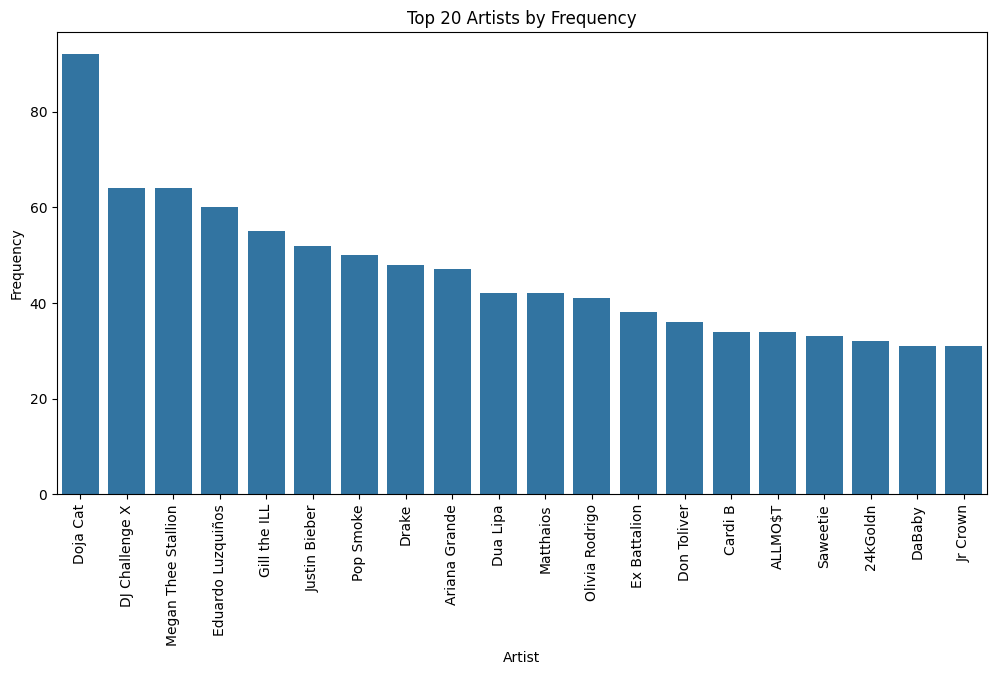


Artist of index 397 is DJ Challenge X


In [ ]:
artist_counts = original_dataset['artist_name'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=artist_counts.index[:20], y=artist_counts.values[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Artists by Frequency')
plt.xlabel('Artist')
plt.ylabel('Frequency')
plt.show()

# One-hot encode the 'artist' column
one_hot_encoded = pd.get_dummies(original_dataset['artist_name'])

# Assuming you've done one-hot encoding, here is an example mapping
artist_columns = one_hot_encoded.columns.tolist()

# Example: You want to find the artist corresponding to 'artist_397'

artist_index = 397
artist_column_name = artist_columns[artist_index]  # Replace 397 with the correct index
print()
print("Artist of index", artist_index, "is", artist_column_name)

##Experiment 1 - Linear Regression (~2 min runtime)

In [ ]:
lr_regressor, linear_regression_y_pred = train_linear_regression(X_train, X_test, y_train, y_test)

['Mean Squared Error: 1106.0537', 'R² Score: -0.8542']


###Hyperparameter Tuning and Visuals

####Scatter Plot

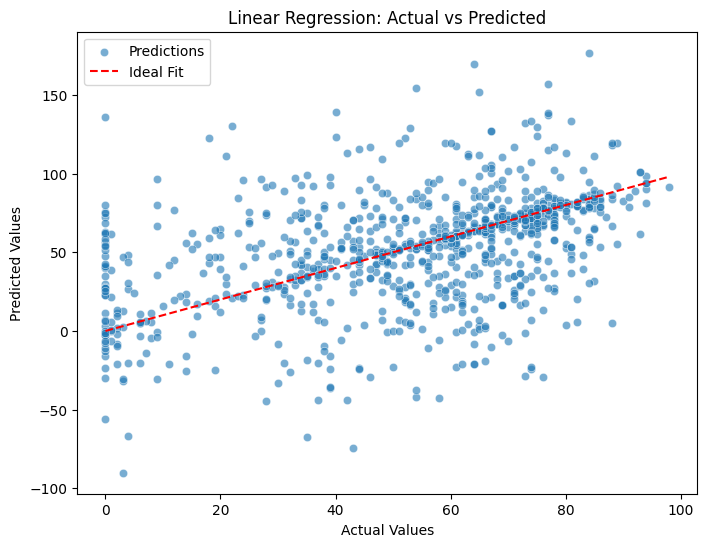

In [ ]:
# Assuming y_test and y_pred are your actual and predicted values
plt.figure(figsize=(8, 6))

sns.scatterplot(x=y_test, y=linear_regression_y_pred, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')  # ideal line (y=x)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

####Coefficient Evaluation

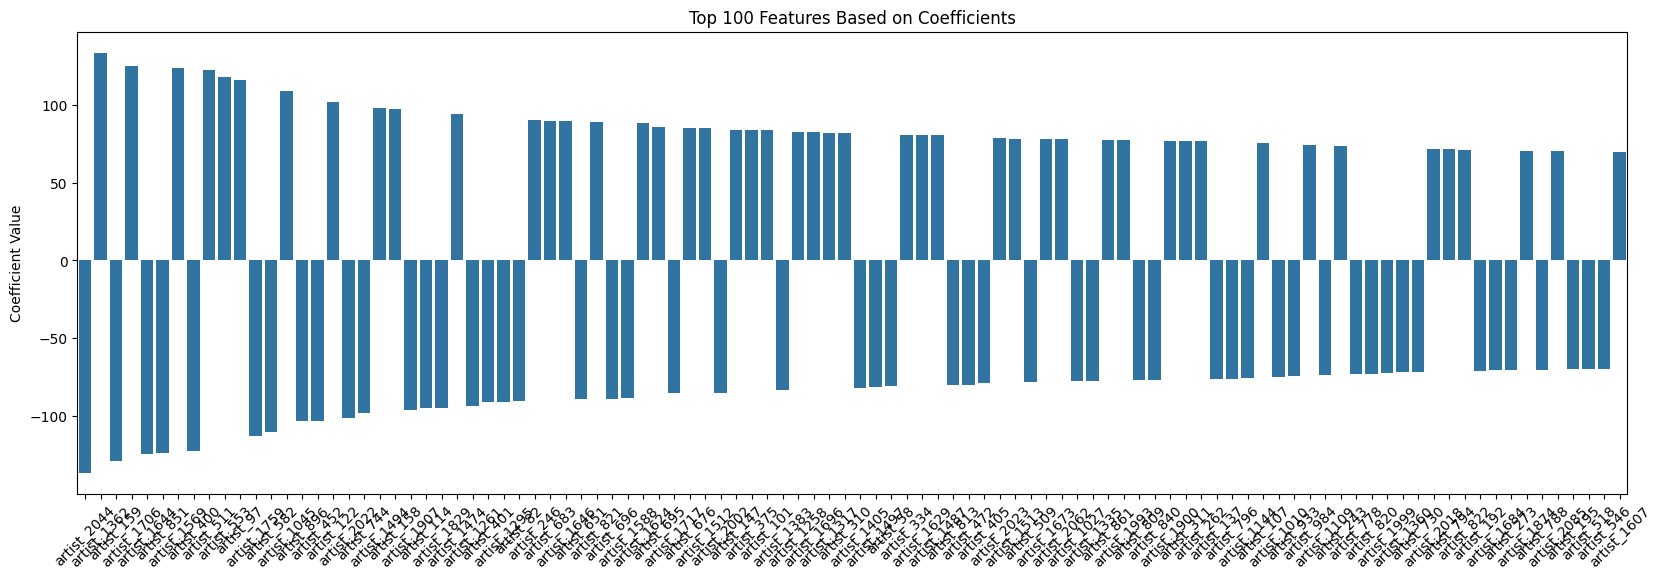

In [ ]:
# Assuming you're using a model with coefficients like LinearRegression()
coefs = lr_regressor.coef_
features = X_train.columns

# Sort coefficients by absolute value to get the top features
sorted_idx = np.argsort(np.abs(coefs))[::-1]  # Sort descending by absolute value
top_n = 100  # You can change this to display more/less features

# Select the top N features and their corresponding coefficients
top_features = [features[i] for i in sorted_idx[:top_n]]
top_coefs = coefs[sorted_idx[:top_n]]

# Create a bar plot for the top features and their coefficients
plt.figure(figsize=(20, 6))
sns.barplot(x=top_features, y=top_coefs)

plt.title(f'Top {top_n} Features Based on Coefficients')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()


##Experiment 2 - Random Forest (5 - 18 min. rutime (took 5 for me)

In [ ]:
rf_model, rf_y_pred = train_random_forest(X_train, X_test, y_train, y_test)

['Mean Squared Error: 318.3682', 'R² Score: 0.4663']


###Hyperparameter Tuning and Visualizations

####Top N Features

In [ ]:
def plot_feature_importance(model, X_train, top_n=10):
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances[sorted_idx][:top_n],
                y=X_train.columns[sorted_idx][:top_n],
                orient='h')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

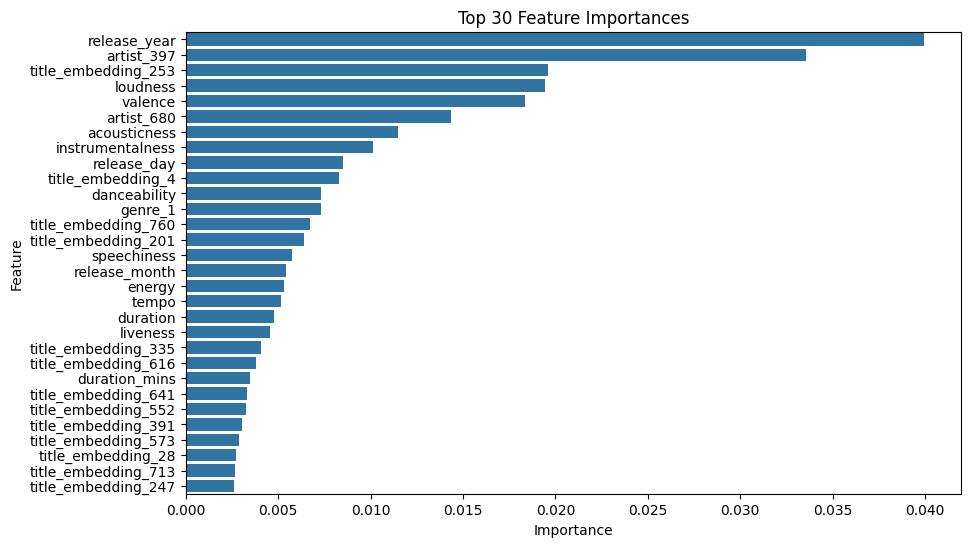

In [ ]:
plot_feature_importance(rf_model, X_train, top_n=30)

#### Residuals Plot

In [ ]:
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.hlines(0, min(y_pred), max(y_pred), colors='red', linestyles='--')
    plt.title('Residuals vs Predicted')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

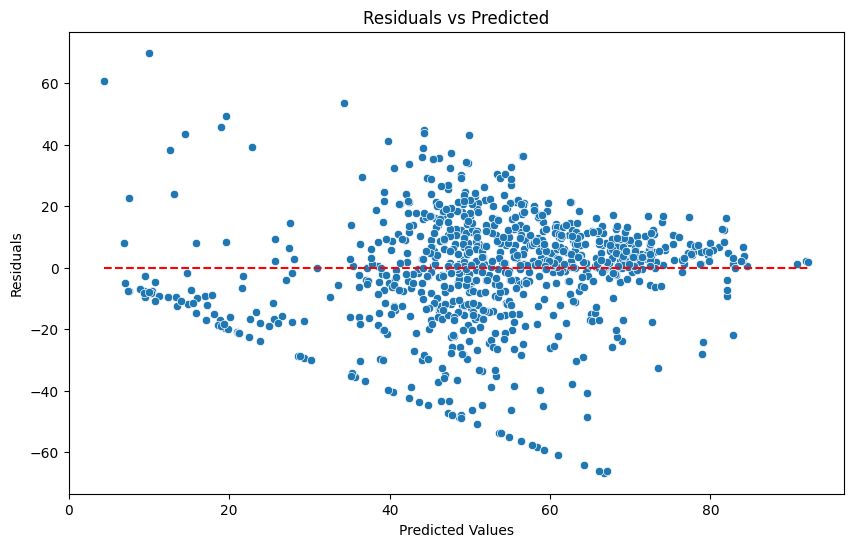

In [ ]:
plot_residuals(y_test, rf_y_pred)

####Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"CV Scores: {scores}")
print(f"Mean R²: {scores.mean():.4f} ± {scores.std():.4f}")

CV Scores: [0.36204958 0.41093445 0.40194936 0.38026294 0.34197894]
Mean R²: 0.3794 ± 0.0253


###Retrial 1 - Only Top N Features selected

n = 100, 50



In [ ]:
# Step 1: Get the feature importances from the trained RandomForest model
feature_importances = rf_model.feature_importances_

# Step 2: Get the feature names (if X_train is a pandas DataFrame)
features = X_train.columns

# Step 3: Sort features by importance in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

n = 50

# Step 4: Get the top n most important features
top_n_features = features[sorted_idx][:n]

# Step 5: Subset the original dataset to only include the top 100 features
X_train_top_n = X_train[top_n_features]
X_test_top_n = X_test[top_n_features]  # Apply same transformation to the test data

# Now you can train a new model using these top 100 features
rf_model_top_n = RandomForestRegressor()
rf_model_top_n.fit(X_train_top_n, y_train)

# Make predictions using the top 100 features
rf_y_pred_top_n = rf_model_top_n.predict(X_test_top_n)

# Evaluate the new model's performance (you can use your existing evaluation methods like MSE, R^2)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, rf_y_pred_top_n)
r2 = r2_score(y_test, rf_y_pred_top_n)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 311.9490
R² Score: 0.4770


####Results

Reducing features down to 100, reduced error to 309, with R^2 of 0.4571. Reducing to 50 had no improvement, with MSE 311.1337, R^2 of 0.4784.

##Experiment 3 - PCA

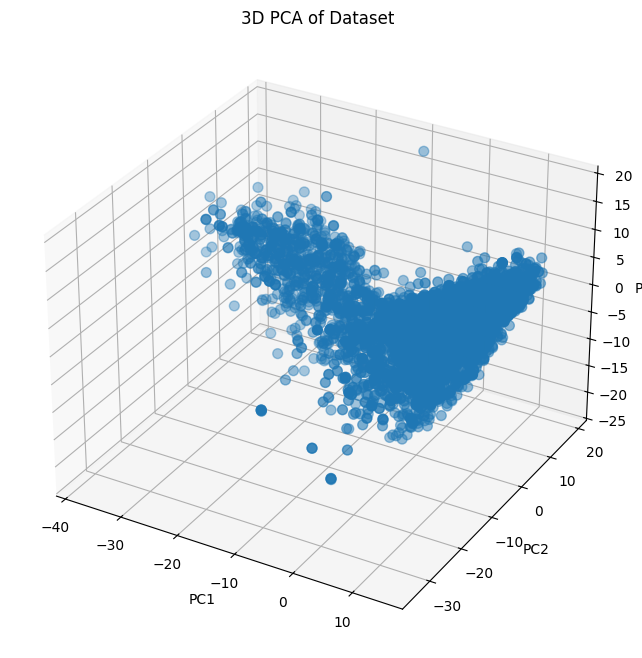

Explained Variance Ratio: [0.05091783 0.0163113  0.0125153 ]
Total Variance Explained: 0.07974443972323153


In [ ]:
# Assuming your dataset is in a pandas DataFrame (data)
# Let's assume the dataset contains only the features (exclude target/label columns)

# Step 1: Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

components = 3

# Step 2: Apply PCA
pca = PCA(n_components=3)  # You can specify the number of components, or use 'n_components=0.95' to preserve 95% variance
principal_components = pca.fit_transform(features_scaled)

# Convert the principal components into a DataFrame
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Step 3: Visualize the results (for 3 components)
# A 3D plot is best to visualize 3 components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Dataset')
plt.show()

# Step 4: Explained Variance Ratio
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained: {sum(pca.explained_variance_ratio_)}')


##Experiment 4 - Multilayer Perceptron (MLP)

In [ ]:
mlp_model = train_mlp(X_train, X_test, y_train, y_test)

[MLP] MSE: 1597.8555 | R²: -1.6787


###Hyperparameter Tuning and Visualizations

Model is doing significantly worse than Random Forest.

Tests:
- Normalize and Scale features appropiately
- Change hyperparameters: epoch, lr
- Add more layers



####Test 1: Normalize and Scale features appropiately

In [ ]:
scaler = StandardScaler()

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape to 2D array
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))  # Reshape to 2D array

EPOCHS=100
LEARNING_RATE=1e-3

mlp_model, train_losses, val_losses = train_mlp_standard_scale(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, epochs=EPOCHS,lr=LEARNING_RATE)

Epoch 1/100 | Train Loss: 1.0416 | Validation Loss: 0.9090 | R²: 0.0486
Epoch 2/100 | Train Loss: 0.9504 | Validation Loss: 0.8715 | R²: 0.0878
Epoch 3/100 | Train Loss: 0.8804 | Validation Loss: 0.8455 | R²: 0.1151
Epoch 4/100 | Train Loss: 0.8229 | Validation Loss: 0.8284 | R²: 0.1330
Epoch 5/100 | Train Loss: 0.7730 | Validation Loss: 0.8115 | R²: 0.1506
Epoch 6/100 | Train Loss: 0.7228 | Validation Loss: 0.7918 | R²: 0.1712
Epoch 7/100 | Train Loss: 0.6640 | Validation Loss: 0.7656 | R²: 0.1987
Epoch 8/100 | Train Loss: 0.6076 | Validation Loss: 0.7347 | R²: 0.2310
Epoch 9/100 | Train Loss: 0.5487 | Validation Loss: 0.7051 | R²: 0.2620
Epoch 10/100 | Train Loss: 0.4878 | Validation Loss: 0.6754 | R²: 0.2930
Epoch 11/100 | Train Loss: 0.4365 | Validation Loss: 0.6489 | R²: 0.3209
Epoch 12/100 | Train Loss: 0.3949 | Validation Loss: 0.6340 | R²: 0.3364
Epoch 13/100 | Train Loss: 0.3472 | Validation Loss: 0.6277 | R²: 0.3430
Epoch 14/100 | Train Loss: 0.3189 | Validation Loss: 0.6285 

####Result:

Final [MLP] MSE: 0.5967 | R²: 0.3755

####Test 1 Chart: Learning Curves and Accuracy

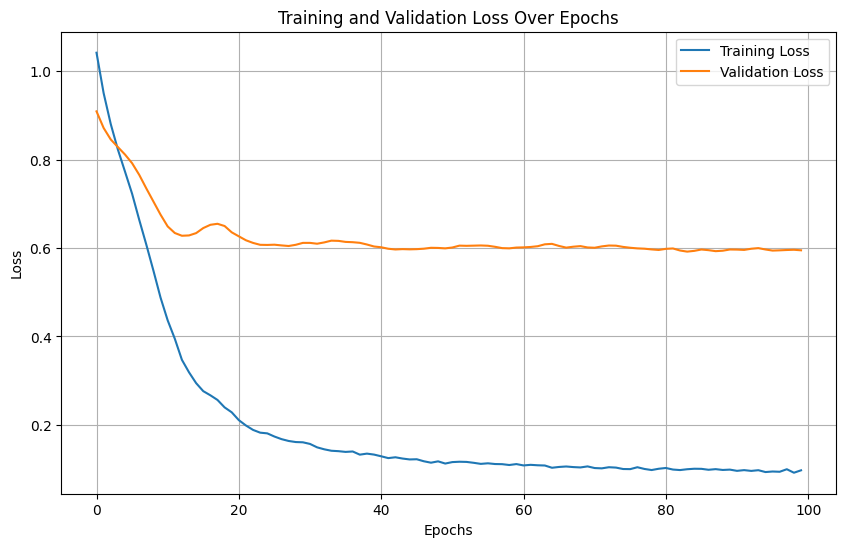

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), train_losses, label='Training Loss')
plt.plot(range(EPOCHS), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

####Test 2: Hyperparameter and Tuning

In [ ]:
EPOCHS=200
LEARNING_RATE=1e-3

mlp_model, train_losses, val_losses = train_mlp_standard_scale(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, epochs=EPOCHS,lr=LEARNING_RATE)

Epoch 1/200 | Train Loss: 1.0508 | Validation Loss: 0.8935 | R²: 0.0648
Epoch 2/200 | Train Loss: 0.9226 | Validation Loss: 0.8489 | R²: 0.1115
Epoch 3/200 | Train Loss: 0.8438 | Validation Loss: 0.8358 | R²: 0.1252
Epoch 4/200 | Train Loss: 0.7914 | Validation Loss: 0.8252 | R²: 0.1362
Epoch 5/200 | Train Loss: 0.7421 | Validation Loss: 0.8014 | R²: 0.1612
Epoch 6/200 | Train Loss: 0.6786 | Validation Loss: 0.7653 | R²: 0.1989
Epoch 7/200 | Train Loss: 0.6181 | Validation Loss: 0.7271 | R²: 0.2389
Epoch 8/200 | Train Loss: 0.5550 | Validation Loss: 0.6914 | R²: 0.2763
Epoch 9/200 | Train Loss: 0.4933 | Validation Loss: 0.6600 | R²: 0.3092
Epoch 10/200 | Train Loss: 0.4399 | Validation Loss: 0.6370 | R²: 0.3333
Epoch 11/200 | Train Loss: 0.3892 | Validation Loss: 0.6255 | R²: 0.3453
Epoch 12/200 | Train Loss: 0.3453 | Validation Loss: 0.6238 | R²: 0.3471
Epoch 13/200 | Train Loss: 0.3145 | Validation Loss: 0.6236 | R²: 0.3473
Epoch 14/200 | Train Loss: 0.2992 | Validation Loss: 0.6264 

####Results

Epoch 194/200 | Train Loss: 0.0751 | Validation Loss: 0.5795 | R²: 0.3934

####Test 2 Chart

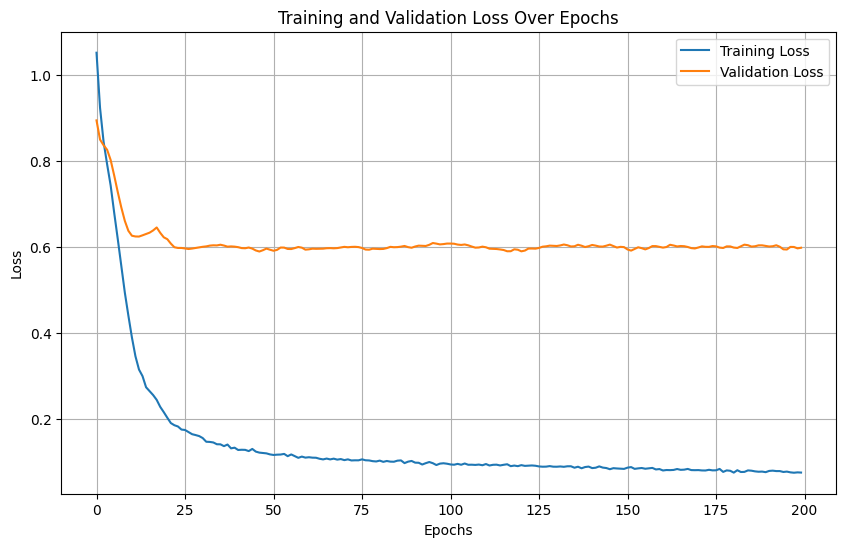

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), train_losses, label='Training Loss')
plt.plot(range(EPOCHS), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##Experiment 5 - MLP with learned embeddings for categorical inputs

In [ ]:
X_num, X_cat, y = preprocessing_no_encodings(original_dataset, preprocessed_dataset)

In [ ]:
scaler_x = StandardScaler()
X_num = scaler_x.fit_transform(X_num)

for col in X_cat.columns:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [ ]:
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_num, X_cat, y_scaled, test_size=0.2, random_state=42
)

cat_dims = [
    X_train_cat[col].nunique() for col in X_train_cat.columns
]

EPOCHS=300
LEARNING_RATE=3e-3

In [ ]:
mlp_embeddings_mode, train_losses, val_losses = train_mlp_with_embeddings(X_train_num, X_test_num, X_train_cat.values, X_test_cat.values, y_train, y_test, cat_dims, EPOCHS, LEARNING_RATE)

X_train_num shape: (3650, 16)
X_train_cat shape: (3650, 2)
cat_dims: [1324, 4]
Epoch 10/300 | Train Loss: 0.7849 | Val Loss: 0.8164
Epoch 20/300 | Train Loss: 0.6489 | Val Loss: 0.7156
Epoch 30/300 | Train Loss: 0.5274 | Val Loss: 0.6390
Epoch 40/300 | Train Loss: 0.4344 | Val Loss: 0.6085
Epoch 50/300 | Train Loss: 0.3545 | Val Loss: 0.5826
Epoch 60/300 | Train Loss: 0.2969 | Val Loss: 0.5689
Epoch 70/300 | Train Loss: 0.2518 | Val Loss: 0.5667
Epoch 80/300 | Train Loss: 0.2178 | Val Loss: 0.5641
Epoch 90/300 | Train Loss: 0.1886 | Val Loss: 0.5678
Epoch 100/300 | Train Loss: 0.1696 | Val Loss: 0.5674
Epoch 110/300 | Train Loss: 0.1545 | Val Loss: 0.5662
Epoch 120/300 | Train Loss: 0.1400 | Val Loss: 0.5687
Epoch 130/300 | Train Loss: 0.1359 | Val Loss: 0.5753
Epoch 140/300 | Train Loss: 0.1247 | Val Loss: 0.5801
Epoch 150/300 | Train Loss: 0.1142 | Val Loss: 0.5814
Epoch 160/300 | Train Loss: 0.1085 | Val Loss: 0.5782
Epoch 170/300 | Train Loss: 0.1032 | Val Loss: 0.5779
Epoch 180/30

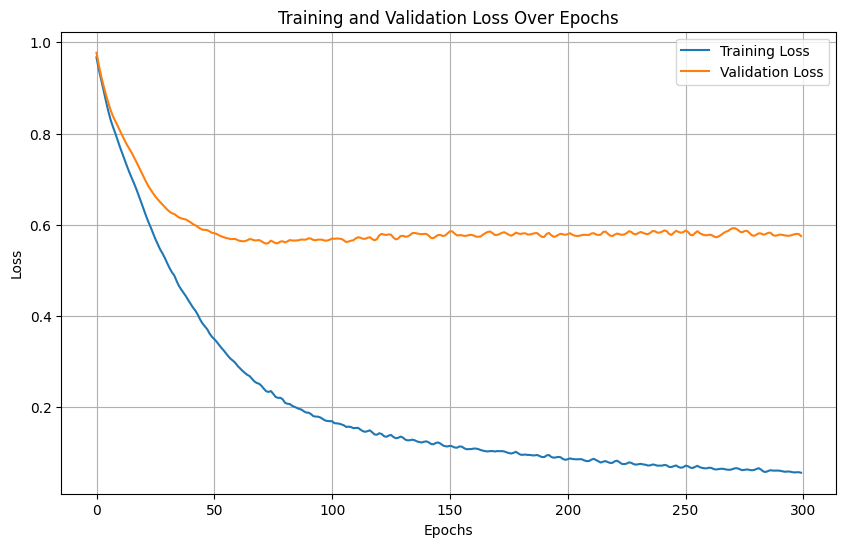

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), train_losses, label='Training Loss')
plt.plot(range(EPOCHS), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()